## Libraries and Dependencies

In [1]:
import torch
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import norm
from pyDOE import lhs
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1 #神经网络的层数
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #激活函数为tanh
        
        layer_list = list() # 创建一个空列表 layer_list，用于存储神经网络的层和激活函数。
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        ) # 向 layer_list 添加输出层
        layerDict = OrderedDict(layer_list) #存储按顺序排列的层和激活函数
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, sigma, r):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.S_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.S_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.sigma = sigma
        self.r = r
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        self.loss_history = []
        self.time_history = []
        
    def net_u(self, S, t):  
        u = self.dnn(torch.cat([S, t], dim=1)) # dim = 1 :按行并排
        return u
    
    def net_f(self, S, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(S, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_S = torch.autograd.grad(
            u, S, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_SS = torch.autograd.grad(
            u_S, S, 
            grad_outputs=torch.ones_like(u_S),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + 0.5 * self.sigma**2 * S**2 * u_SS + self.r * S * u_S - self.r * u
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.S_u, self.t_u)
        f_pred = self.net_f(self.S_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        self.loss_history.append(loss.item())
        self.time_history.append(time.time())
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        S = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(S, t)
        f = self.net_f(S, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [5]:
# Exact solution (Black-Scholes formula for European call option)
def black_scholes(S, K, T, t, r, sigma):
    from scipy.stats import norm
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    return S * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)

## Configurations

In [35]:
# 实验参数
Nu_values = [250 , 500 , 750 , 1000]  # 初始条件点数
Nf_values = [1000 ,5000 , 10000, 15000]  # 训练点数

# 结果存储
errors_Nu_Nf = np.zeros((len(Nu_values), len(Nf_values)))  # 热力图数据


In [36]:
for i,N_u in enumerate(Nu_values):
    for j,N_f in enumerate(Nf_values):
        # Parameters for Black-Scholes equation
        sigma = 0.2
        r = 0.05
        T = 1.0  # 到期时间
        K = 50  # 执行价格

        # Domain bounds for stock price and time
        S_min = 0.0
        S_max = 100.0
        t_min = 0.0
        t_max = T

        # Define the neural network structure
        layers = [2, 30, 30, 30, 30, 30, 30, 1]
        # Initial condition: European Call Option Payoff at t = T
        S_0 = np.linspace(S_min, S_max, N_u)[:, None]
        t_0 = np.ones((N_u, 1))
        u_0 = np.maximum(S_0 - K, 0)
        # Collocation points
        X_f_train = np.hstack((S_min + (S_max - S_min) * lhs(1, N_f), t_min + (t_max - t_min) * lhs(1, N_f)))

        # Combine all training data
        X_u_train = np.hstack([S_0, t_0])
        u_train = u_0

        # Randomly sample initial condition points
        idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
        X_u_train = X_u_train[idx, :]
        u_train = u_train[idx, :]
        # Initialize the Physics Informed Neural Network
        model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, [S_min, t_min], [S_max, t_max], sigma, r)
        model.train()
        # Predict using the trained model
        S_star = np.linspace(S_min, S_max, 100)[:, None]
        t_star = np.linspace(t_min, t_max, 100)[:, None]
        S_star, t_star = np.meshgrid(S_star, t_star)
        X_star = np.hstack((S_star.flatten()[:, None], t_star.flatten()[:, None]))

        u_pred, f_pred = model.predict(X_star)

        # Compute exact solution
        u_exact = black_scholes(S_star.flatten(), K, T, t_star.flatten(), r, sigma)

        # Compute error
        error_u = np.linalg.norm(u_exact - u_pred.flatten(), 2) / np.linalg.norm(u_exact, 2)
        print('Error u: %e' % (error_u))
        errors_Nu_Nf[i, j] = error_u # 存储误差

Iter 100, Loss: 3.64110e+00, Loss_u: 1.99444e+00, Loss_f: 1.64666e+00
Iter 200, Loss: 3.85725e-01, Loss_u: 1.73631e-01, Loss_f: 2.12095e-01
Iter 300, Loss: 2.52042e-01, Loss_u: 1.62359e-01, Loss_f: 8.96829e-02
Iter 400, Loss: 1.78626e-01, Loss_u: 1.21555e-01, Loss_f: 5.70709e-02
Iter 500, Loss: 1.57567e-01, Loss_u: 1.07432e-01, Loss_f: 5.01356e-02
Iter 600, Loss: 1.44111e-01, Loss_u: 9.90756e-02, Loss_f: 4.50358e-02
Iter 700, Loss: 1.26456e-01, Loss_u: 8.94560e-02, Loss_f: 3.70005e-02
Iter 800, Loss: 1.20300e-01, Loss_u: 8.52627e-02, Loss_f: 3.50372e-02
Iter 900, Loss: 1.13172e-01, Loss_u: 8.07653e-02, Loss_f: 3.24063e-02
Iter 1000, Loss: 1.10217e-01, Loss_u: 8.00110e-02, Loss_f: 3.02057e-02
Iter 1100, Loss: 1.01588e-01, Loss_u: 7.01774e-02, Loss_f: 3.14107e-02
Iter 1200, Loss: 9.54136e-02, Loss_u: 6.24021e-02, Loss_f: 3.30115e-02
Iter 1300, Loss: 8.82536e-02, Loss_u: 5.43927e-02, Loss_f: 3.38610e-02
Iter 1400, Loss: 8.72014e-02, Loss_u: 5.15275e-02, Loss_f: 3.56738e-02
Iter 1500, Loss

In [18]:
errors_Nu_Nf

array([[0.00164575, 0.01891784, 0.02513161, 0.00400781],
       [0.00436234, 0.01870756, 0.00734196, 0.02552081],
       [0.00605944, 0.03189802, 0.01011039, 0.00842101],
       [0.00459124, 0.01071079, 0.02451512, 0.00502265]])

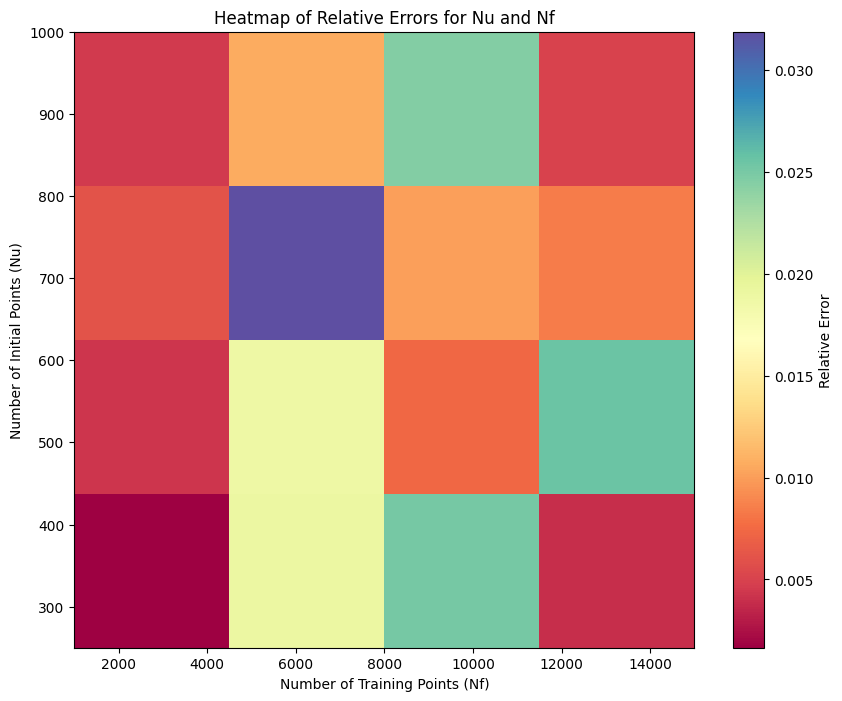

In [34]:
# 绘制热力图
plt.figure(figsize=(10, 8))
plt.imshow(errors_Nu_Nf, extent=[min(Nf_values), max(Nf_values), min(Nu_values), max(Nu_values)],
           origin='lower', aspect='auto', cmap='Spectral')
plt.colorbar(label='Relative Error')
plt.xlabel('Number of Training Points (Nf)')
plt.ylabel('Number of Initial Points (Nu)')
plt.title('Heatmap of Relative Errors for Nu and Nf')
plt.show()

In [13]:
# 实验参数
network_architectures = [[2, 5, 5, 5, 5, 5, 5, 1],[2, 10, 10, 10, 10, 10, 10, 1], [2, 20, 20, 20, 20, 20, 20, 1],[2, 30, 30, 30, 30, 30, 30, 1], [2, 40, 40, 40, 40, 40, 40, 1],[2, 50, 50, 50, 50, 50, 50, 1],[2, 60, 60, 60, 60, 60, 60, 1]]  # 不同架构
results_architectures = np.zeros((len(network_architectures), 3))

In [14]:
# 遍历不同的架构
for i, layers in enumerate(network_architectures):
         # Parameters for Black-Scholes equation
        sigma = 0.2
        r = 0.05
        T = 1.0  # 到期时间
        K = 50  # 执行价格

        # Domain bounds for stock price and time
        S_min = 0.0
        S_max = 100.0
        t_min = 0.0
        t_max = T

        # Generating training data
        N_u = 1000  # Number of initial condition points
        N_f = 10000  # Number of collocation points

        # Initial condition: European Call Option Payoff at t = T
        S_0 = np.linspace(S_min, S_max, N_u)[:, None]
        t_0 = np.ones((N_u, 1))
        u_0 = np.maximum(S_0 - K, 0)

        # Collocation points
        X_f_train = np.hstack((S_min + (S_max - S_min) * lhs(1, N_f), t_min + (t_max - t_min) * lhs(1, N_f)))

        # Combine all training data
        X_u_train = np.hstack([S_0, t_0])
        u_train = u_0

        # Randomly sample initial condition points
        idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
        X_u_train = X_u_train[idx, :]
        u_train = u_train[idx, :]
        # Initialize the Physics Informed Neural Network
        model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, [S_min, t_min], [S_max, t_max], sigma, r)
        model.train()
        # Predict using the trained model
        S_star = np.linspace(S_min, S_max, 100)[:, None]
        t_star = np.linspace(t_min, t_max, 100)[:, None]
        S_star, t_star = np.meshgrid(S_star, t_star)
        X_star = np.hstack((S_star.flatten()[:, None], t_star.flatten()[:, None]))

        u_pred, f_pred = model.predict(X_star)

        # Compute exact solution
        u_exact = black_scholes(S_star.flatten(), K, T, t_star.flatten(), r, sigma)

        # Compute error
        error_u = np.linalg.norm(u_exact - u_pred.flatten(), 2) / np.linalg.norm(u_exact, 2)
        results_architectures[i, :] = [len(layers) - 2, layers[1], error_u]
        print('Error u: %e' % (error_u))



Iter 100, Loss: 9.70058e+01, Loss_u: 8.18250e+01, Loss_f: 1.51808e+01
Iter 200, Loss: 1.49431e+01, Loss_u: 5.40260e+00, Loss_f: 9.54054e+00
Iter 300, Loss: 1.67872e+00, Loss_u: 3.34047e-01, Loss_f: 1.34468e+00
Iter 400, Loss: 1.04569e+00, Loss_u: 3.62409e-01, Loss_f: 6.83280e-01
Error u: 3.792742e-02
Iter 100, Loss: 7.81148e+01, Loss_u: 5.81107e+01, Loss_f: 2.00041e+01
Iter 200, Loss: 1.18502e+01, Loss_u: 4.29753e+00, Loss_f: 7.55264e+00
Iter 300, Loss: 2.70690e+00, Loss_u: 1.08599e+00, Loss_f: 1.62091e+00
Iter 400, Loss: 9.07884e-01, Loss_u: 3.27287e-01, Loss_f: 5.80597e-01
Iter 500, Loss: 6.67125e-01, Loss_u: 3.55493e-01, Loss_f: 3.11632e-01
Iter 600, Loss: 6.30227e-01, Loss_u: 3.03844e-01, Loss_f: 3.26384e-01
Iter 700, Loss: 6.07058e-01, Loss_u: 2.73083e-01, Loss_f: 3.33975e-01
Iter 800, Loss: 5.43578e-01, Loss_u: 2.71264e-01, Loss_f: 2.72314e-01
Iter 900, Loss: 5.26096e-01, Loss_u: 2.86676e-01, Loss_f: 2.39420e-01
Iter 1000, Loss: 5.20290e-01, Loss_u: 2.92515e-01, Loss_f: 2.27775e-

In [15]:
results_architectures[:,2]

array([0.03792742, 0.02613905, 0.00377782, 0.00634761, 0.01176155,
       0.00881949, 0.00663964])

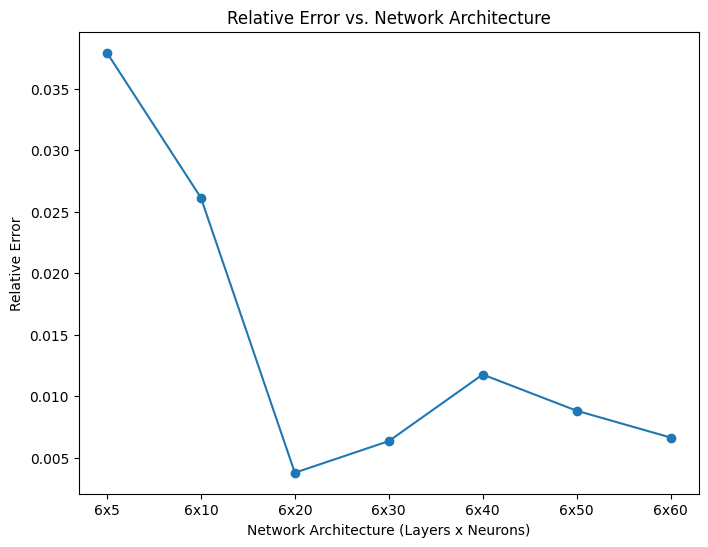

In [16]:
# 绘制折线图：误差随网络架构变化
plt.figure(figsize=(8, 6))
architectures_labels = [f'{len(arch)-2}x{arch[1]}' for arch in network_architectures]  # 格式化标签
plt.plot(architectures_labels, results_architectures[:,2], 'o-', label='Network Architectures')
plt.xlabel('Network Architecture (Layers x Neurons)')
plt.ylabel('Relative Error')
plt.title('Relative Error vs. Network Architecture')
plt.show()